# <u>Order Details Analysis</u>

## About
Boss Leathers is a small leather products business which has recently started selling its products on Amazon. Currently, it has around 40 SKUs registered in the Indian Marketplace. Over the past few months, it has incurred some loss due to return orders. Now, Boss Leather seeks help to predict the liklihood of a new order being rejected. This would help them to take necessary actions and subsequently reduce the loss.

## Objective
To build a model which would predict the order status (`Delivered to buyer` or `Returned to seller`)

## Data Dictionary
The Order data is provided in an excel file. The columns are:
Independent Features:
   1. `order_no` - Unique Amazon Order Number
   
   2. `order_date` - Date on which the order was placed
   
   4. `buyer` - Name of the buyer
   
   3. `ship_city` - Delivery Address City
   
   4. `ship_state` - Delivery Address State
   
   5. `sku - Unique` identifier of a product
   
   6. `description` - Product description
   
   7. `quantity` - Number of units ordered
   
   8. `item_total` - Total amount paid by the buyer
   
   9. `shipping_fee` - Charges borne by Boss Leathers to ship the item
   
   10. `cod` - Mode of payment: Cash on delivery or not
   
Label / Target Feature:
   1. `order_status` - Status of the order

## Analysis Steps:
   - Import libraries
   - Understand the data
   - Handle missing values
   - Format Date Feature
   - Visualize Business Insigths

### Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
warnings.simplefilter('ignore')

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords

%matplotlib inline

In [6]:
df = pd.read_excel('orders_data.xlsx')

In [7]:
df.shape

(171, 12)

In [8]:
def drop(df, *features):
    ''' To drop the features from a dataframe'''
    for i in features:
        df.drop(i, axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   order_no      171 non-null    object
 1   order_date    171 non-null    object
 2   buyer         171 non-null    object
 3   ship_city     171 non-null    object
 4   ship_state    171 non-null    object
 5   sku           171 non-null    object
 6   description   171 non-null    object
 7   quantity      171 non-null    int64 
 8   item_total    153 non-null    object
 9   shipping_fee  145 non-null    object
 10  cod           47 non-null     object
 11  order_status  171 non-null    object
dtypes: int64(1), object(11)
memory usage: 16.2+ KB


In [10]:
df.head(3)

,order_no,order_date,buyer,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status
0,405-9763961-5211537,"Sun, 18 Jul, 2021, 10:38 pm IST",Mr.,"CHANDIGARH,",CHANDIGARH,SKU: 2X-3C0F-KNJE,100% Leather Elephant Shaped Piggy Coin Bank |...,1,₹449.00,NaN,NaN,Delivered to buyer
1,404-3964908-7850720,"Tue, 19 Oct, 2021, 6:05 pm IST",Minam,"PASIGHAT,",ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,₹449.00,₹60.18,NaN,Delivered to buyer
2,171-8103182-4289117,"Sun, 28 Nov, 2021, 10:20 pm IST",yatipertin,"PASIGHAT,",ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,₹449.00,₹60.18,NaN,Delivered to buyer


In [11]:
df['order_status'].value_counts()

Delivered to buyer    160
Returned to seller     11
Name: order_status, dtype: int64

In [36]:
# Convert city and state into uppercase
places = ['ship_city', 'ship_state']
for i in places:
    df[i] = df[i].apply(lambda x: x.upper())

In [37]:
# removing comma from city values
df['ship_city'] = df['ship_city'].apply(lambda x: x.replace(',', ''))
df['ship_state'] = df['ship_state'].apply(lambda x: x.replace(',', ''))

In [38]:
df.isnull().sum()

order_no          0
order_date        0
buyer             0
ship_city         0
ship_state        0
sku               0
description       0
quantity          0
item_total       18
shipping_fee     26
cod             124
order_status      0
dtype: int64

### Handle Missing Values
There are 3 features with missing values: cod, item_total and shipping fee

In [39]:
# imputing with mode as shipping fee is fixed based on package size and weight
df['shipping_fee'].fillna(df['shipping_fee'].mode()[0], inplace=True)

# imputing with mode as we are considering the item that is sold the most
df['item_total'].fillna(df['item_total'].mode()[0], inplace=True)

# assuming if an order is not cod would mean the mode of payment is online
df['cod'].fillna('online', inplace=True)

In [40]:
# remove rupee symbol from amount features
amounts = ['item_total', 'shipping_fee']
for i in amounts:
    df[i] = df[i].apply(lambda x: x.replace(',', ''))        # remove the commas in amounts greater than 1000
    df[i] = df[i].apply(lambda x: x[1:])

In [41]:
# change data types
i = 'int64'
f = 'float64'
df = df.astype({'item_total': f, 'shipping_fee': f, 'quantity': i})

In [42]:
df.head(3)

,order_no,order_date,buyer,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status
0,405-9763961-5211537,"Sun, 18 Jul, 2021, 10:38 pm IST",Mr.,CHANDIGARH,CHANDIGARH,SKU: 2X-3C0F-KNJE,100% Leather Elephant Shaped Piggy Coin Bank |...,1,449.0,84.96,online,Delivered to buyer
1,404-3964908-7850720,"Tue, 19 Oct, 2021, 6:05 pm IST",Minam,PASIGHAT,ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,449.0,60.18,online,Delivered to buyer
2,171-8103182-4289117,"Sun, 28 Nov, 2021, 10:20 pm IST",yatipertin,PASIGHAT,ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,449.0,60.18,online,Delivered to buyer


## <u>Drawing Business Insights:</u>

We will try to answer few questions:
   - Is order success dependant on mode of payment?
   - Sales Trend (Sales Pattern over the period)
   - Which days of the week draw more sales?
   - People from which states are ordering the most
   - Which are the top sold products?
   - What percentage of orders have been returned?
   - Most popular keywords among the customers

### cod distribution

In [43]:
df[['cod', 'order_status', 'item_total']].groupby(['cod', 'order_status']).sum().reset_index()

,cod,order_status,item_total
0,Cash On Delivery,Delivered to buyer,23812.0
1,Cash On Delivery,Returned to seller,2245.0
2,online,Delivered to buyer,68508.0
3,online,Returned to seller,2694.0


In [44]:
fig = px.histogram(df, x="cod", y="item_total", color='order_status', barmode='group', height=400)
fig.show()

We see that most of the orders were prepaid and the percentage of return orders is more in cod mode.

### Format date

In [45]:
# extract year, month, day and time from date feature
df['year'] = pd.DatetimeIndex(df['order_date']).year
df['date'] = pd.DatetimeIndex(df['order_date']).date
df['time'] = pd.DatetimeIndex(df['order_date']).time
df['month_name'] = pd.DatetimeIndex(df['date']).month_name()
df['day_name'] = pd.DatetimeIndex(df['date']).day_name()

In [46]:
drop(df, 'order_date')
df.head(2)

,order_no,buyer,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status,year,date,time,month_name,day_name
0,405-9763961-5211537,Mr.,CHANDIGARH,CHANDIGARH,SKU: 2X-3C0F-KNJE,100% Leather Elephant Shaped Piggy Coin Bank |...,1,449.0,84.96,online,Delivered to buyer,2021,2021-07-18,22:38:00,July,Sunday
1,404-3964908-7850720,Minam,PASIGHAT,ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,449.0,60.18,online,Delivered to buyer,2021,2021-10-19,18:05:00,October,Tuesday


In [47]:
# Extracting the unique identifier
df['sku'] = df['sku'].apply(lambda x: x[4:])
df.head(2)

,order_no,buyer,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status,year,date,time,month_name,day_name
0,405-9763961-5211537,Mr.,CHANDIGARH,CHANDIGARH,2X-3C0F-KNJE,100% Leather Elephant Shaped Piggy Coin Bank |...,1,449.0,84.96,online,Delivered to buyer,2021,2021-07-18,22:38:00,July,Sunday
1,404-3964908-7850720,Minam,PASIGHAT,ARUNACHAL PRADESH,DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,449.0,60.18,online,Delivered to buyer,2021,2021-10-19,18:05:00,October,Tuesday


In [48]:
df_sales = df[['date', 'item_total']].groupby('date').sum().reset_index()
df_sales.head(3)

,date,item_total
0,2021-06-13,175.0
1,2021-06-16,525.0
2,2021-06-17,200.0


In [49]:
fig = px.line(df_sales, x='date', y="item_total", title = 'Sales over the period')
fig.show()

There hasn't been any significant growth over the period. December month saw the maximum sales with a couple of breakthroughs. 

In [50]:
df_days = df[['year', 'month_name', 'day_name', 'item_total']].groupby(['year', 'month_name', 'day_name']).sum().reset_index()
# df_days.sort_values(by=['year', 'month_name'])

In [51]:
fig = px.bar(df_days, x="month_name", y="item_total", color="day_name", title="Month-wise Sales")
fig.show()

In [52]:
df_places = df[['ship_state', 'ship_city', 'item_total']].groupby(['ship_state', 'ship_city']).sum().reset_index()
df_places.sort_values(by='item_total', ascending=False, inplace=True)

In [53]:
fig = px.sunburst(data_frame=df_places, path=['ship_state', 'ship_city'], values='item_total', title='Region-wise orders')
fig.show()

In [54]:
top_cities = df.groupby('ship_city').size().reset_index().rename(columns={0: 'Total'}).sort_values('Total', ascending=False).head()
fig = px.pie(top_cities, values='Total', names='ship_city', color_discrete_sequence=px.colors.sequential.RdBu, title='Top 5 ordering cities')
fig.show()

In [55]:
top_cities = df.groupby('sku').size().reset_index().rename(columns={0: 'Total'}).sort_values('Total', ascending=False).head()
fig = px.pie(top_cities, values='Total', names='sku', color_discrete_sequence=px.colors.sequential.BuGn_r, title='Top 5 Products')
fig.show()

In [56]:
df['order_status'].value_counts()

Delivered to buyer    160
Returned to seller     11
Name: order_status, dtype: int64

In [61]:
df_status = df[['order_status', 'item_total']]
fig = px.bar(data_frame=df_status, x='order_status', y='item_total', color='order_status', title='Success rate of orders')
fig.show()

From the above we can find the order value of each of success and return orders

In [62]:
df['description'] = df['description'].apply(lambda x: x.replace('|', ''))

In [63]:
stop_words = stopwords.words('english')
stop_words.extend(['Pure', 'Leather', 'Shantiniketan', 'with', 'clean_dedsc', 'phone', 'for', 'and', 'print', 'block', 'dtype'])

In [64]:
# Remove stop words and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return ' '.join(result)

In [65]:
# cleaned data
df['clean_desc'] = df['description'].apply(preprocess)

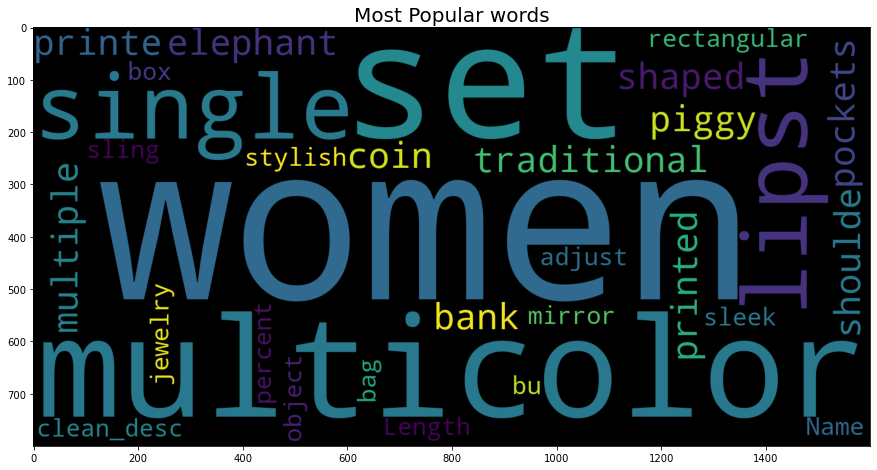

In [66]:
plt.figure(figsize=(15,10))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(str(df[df['order_status']=='Delivered to buyer'].clean_desc))
plt.title('Most Popular words', fontsize=20)
plt.imshow(wc)

## Conclusions

We have extracted quite a few key inferences:
   - The dataset came with some missing values in 2 of its features
   - Order return rates are higher in COD type orders
   - The sales has been stagnant throughout with few breakthroughs in December 
   - We visualized the sales across the months grouped by day of week to find that Sundays and Wednesdays dominate over the sales whereas the least contributor turned out to be the Saturdays
   - We saw the region wise order amounts
   - Top ordering cities are: Mumbai, Kolkata, Bangalore, Chennai and Pune
   - We identified the top selling products
   - The Barplot of order status tells us that there is less than 10% of return orders
   - In the word cloud we see which are the most popular categories among the customers

**Further Analysis in progress**